# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [236]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [237]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [238]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


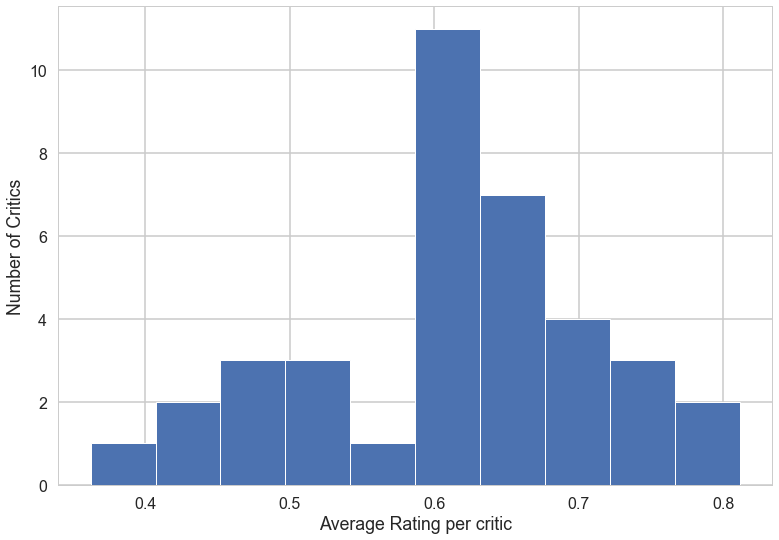

In [239]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [240]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [241]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

your turn

In [242]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [243]:
# import and instantiate MultinomialNB
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [244]:
# train the model
clf.fit(X_train, y_train)
score_test=clf.score(X_test, y_test)
score_test

0.78334618350038554

In [245]:
# calculate score for train and test
score_train=clf.score(X_train,y_train)
print('train: %s' % score_train)
print('test : %s' % score_test)

train: 0.919023136247
test : 0.7833461835


In [246]:
# check if the model is generalizing well (ie. not overfitting)
from sklearn.model_selection import cross_val_score
cross_val_score(MultinomialNB(), X, y, cv=5)

array([ 0.76742692,  0.77031802,  0.75192802,  0.76381748,  0.7672774 ])

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

Your turn

In [247]:
vect = CountVectorizer(min_df=0., max_df=1.0)
X = vect.fit_transform(critics.quote.values)

dfx =pd.DataFrame(X.toarray(), columns=vect.get_feature_names()).T

dfx["sum"] = dfx.sum(axis=1)
dfx = dfx['sum'].to_frame() # more efficient than dfx[['sum']]
dfx = dfx.reset_index()
dfx.columns = ['word', 'documents']

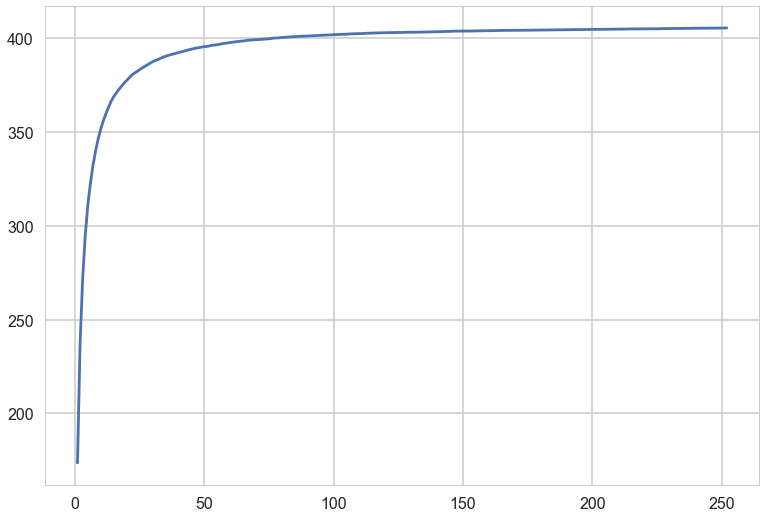

In [248]:
dfx2 = dfx.groupby('documents').count().reset_index()
dfx2.columns = ['documents', 'words']

total_words = len(dfx2['words'].unique())
x = dfx2['documents'].values 
y = np.cumsum(dfx2['words'].values) / total_words

plt.plot(x[0:200], y[0:200])

use grid search: 
min_df=[1,2,3,4,5,6,7,8,9,10]
max_df=[100,125,150,175,200,300,400,500,1000]

In [255]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', MultinomialNB()),
                      ])

from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__alpha': (0.01, 0.001),}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [256]:
gs_clf.fit(X_train, y_train)

JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x10e13aa50, file "/Use...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/bernadett/miniconda3/lib/python3.5/site-p...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/bernadett/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/berna.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10e13aa50, file "/Use...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/bernadett/miniconda3/lib/python3.5/site-p...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/bernadett/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/berna.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'gs_clf.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 4, 26, 17, 25, 17, 50693, tzinfo=datetime.timezone.utc), 'msg_id': 'A0EF4020B4E64416A46FB0C0158D8DC0', 'msg_type': 'execute_request', 'session': 'EC183F45C91948058026E76F54FECA16', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A0EF4020B4E64416A46FB0C0158D8DC0', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'EC183F45C91948058026E76F54FECA16']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'gs_clf.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 4, 26, 17, 25, 17, 50693, tzinfo=datetime.timezone.utc), 'msg_id': 'A0EF4020B4E64416A46FB0C0158D8DC0', 'msg_type': 'execute_request', 'session': 'EC183F45C91948058026E76F54FECA16', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A0EF4020B4E64416A46FB0C0158D8DC0', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'EC183F45C91948058026E76F54FECA16'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'gs_clf.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 4, 26, 17, 25, 17, 50693, tzinfo=datetime.timezone.utc), 'msg_id': 'A0EF4020B4E64416A46FB0C0158D8DC0', 'msg_type': 'execute_request', 'session': 'EC183F45C91948058026E76F54FECA16', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A0EF4020B4E64416A46FB0C0158D8DC0', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='gs_clf.fit(X_train, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'gs_clf.fit(X_train, y_train)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('gs_clf.fit(X_train, y_train)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('gs_clf.fit(X_train, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='gs_clf.fit(X_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2678                 self.displayhook.exec_result = result
   2679 
   2680                 # Execute the user code
   2681                 interactivity = "none" if silent else self.ast_node_interactivity
   2682                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2683                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2684                 
   2685                 self.last_execution_succeeded = not has_raised
   2686 
   2687                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-256-8de7cae3c0d8>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1c5830c50, execution_..._before_exec=None error_in_exec=None result=None>)
   2788                     return True
   2789 
   2790             for i, node in enumerate(to_run_interactive):
   2791                 mod = ast.Interactive([node])
   2792                 code = compiler(mod, cell_name, "single")
-> 2793                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1c8ce0270, file "<ipython-input-256-8de7cae3c0d8>", line 1>
        result = <ExecutionResult object at 1c5830c50, execution_..._before_exec=None error_in_exec=None result=None>
   2794                     return True
   2795 
   2796             # Flush softspace
   2797             if softspace(sys.stdout, 0):

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1c8ce0270, file "<ipython-input-256-8de7cae3c0d8>", line 1>, result=<ExecutionResult object at 1c5830c50, execution_..._before_exec=None error_in_exec=None result=None>)
   2842         outflag = True  # happens in more places, so it's easier as default
   2843         try:
   2844             try:
   2845                 self.hooks.pre_run_code_hook()
   2846                 #rprint('Running code', repr(code_obj)) # dbg
-> 2847                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1c8ce0270, file "<ipython-input-256-8de7cae3c0d8>", line 1>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Counter': <class 'collections.Counter'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'get_ipython().magic(\'matplotlib inline\')\nimport ....set_style("whitegrid")\nsns.set_context("poster")', "critics = pd.read_csv('./critics.csv')\n#let's dr...= critics[~critics.quote.isnull()]\ncritics.head()", 'n_reviews = len(critics)\nn_movies = critics.rtid...print("Number of movies:  {:d}".format(n_movies))', 'df = critics.copy()\ndf[\'fresh\'] = df.fresh == \'f...ber of Critics")\nplt.yticks([0, 2, 4, 6, 8, 10]);', 'from sklearn.feature_extraction.text import Coun...out the *order* of words, \n# just their frequency', 'def make_xy(critics, vectorizer=None):\n    #Your...e(np.int)\n    return X, y\nX, y = make_xy(critics)', 'from sklearn.model_selection import KFold\ndef cv...held-out data\n    return result / nfold # average', 'def log_likelihood(clf, x, y):\n    prob = clf.pr...turn prob[rotten, 0].sum() + prob[fresh, 1].sum()', 'from sklearn.model_selection import train_test_s...itics.shape[0], dtype=np.bool)\nmask[itest] = True', 'from sklearn.model_selection import train_test_s...itics.shape[0], dtype=np.bool)\nmask[itest] = True', 'from sklearn.naive_bayes import MultinomialNB\n\n#...ask]\n    ytrainthis = ythis[mask]\n    # your turn', 'print("alpha: {}".format(best_alpha))', '# split X and y into training and testing sets\nf..., y_test = train_test_split(X, y, random_state=1)', '# split X and y into training and testing sets\nf..., y_test = train_test_split(X, y, random_state=1)', 'def make_xy(critics, vectorizer=None):\n    #Your...e(np.int)\n    return X, y\nX, y = make_xy(critics)', 'from sklearn.feature_extraction.text import Coun...out the *order* of words, \n# just their frequency', 'def make_xy(critics, vectorizer=None):\n    #Your...e(np.int)\n    return X, y\nX, y = make_xy(critics)', '# split X and y into training and testing sets\nf... X_test, y_train, y_test = train_test_split(X, y)', '# import and instantiate MultinomialNB\nfrom skle..._bayes import MultinomialNB\nclf = MultinomialNB()', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {2:                critic  fresh    imdb     publica...rated, hyperreali...  2008-03-10  9559  Toy story, 20: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 21: 0.77049601644821386, 24: 0.77049601644821386, 52: <15561x22417 sparse matrix of type '<class 'nump...ored elements in Compressed Sparse Column format>, 53: <15561x22417 sparse matrix of type '<class 'nump...ored elements in Compressed Sparse Column format>, 55: array([0, 1, 1, ..., 1, 0, 0]), 62: array([1, 0, 0, ..., 1, 1, 1]), 63: <11670x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 66: <11670x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'TfidfTransformer': <class 'sklearn.feature_extraction.text.TfidfTransformer'>, 'X': <15561x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Counter': <class 'collections.Counter'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'get_ipython().magic(\'matplotlib inline\')\nimport ....set_style("whitegrid")\nsns.set_context("poster")', "critics = pd.read_csv('./critics.csv')\n#let's dr...= critics[~critics.quote.isnull()]\ncritics.head()", 'n_reviews = len(critics)\nn_movies = critics.rtid...print("Number of movies:  {:d}".format(n_movies))', 'df = critics.copy()\ndf[\'fresh\'] = df.fresh == \'f...ber of Critics")\nplt.yticks([0, 2, 4, 6, 8, 10]);', 'from sklearn.feature_extraction.text import Coun...out the *order* of words, \n# just their frequency', 'def make_xy(critics, vectorizer=None):\n    #Your...e(np.int)\n    return X, y\nX, y = make_xy(critics)', 'from sklearn.model_selection import KFold\ndef cv...held-out data\n    return result / nfold # average', 'def log_likelihood(clf, x, y):\n    prob = clf.pr...turn prob[rotten, 0].sum() + prob[fresh, 1].sum()', 'from sklearn.model_selection import train_test_s...itics.shape[0], dtype=np.bool)\nmask[itest] = True', 'from sklearn.model_selection import train_test_s...itics.shape[0], dtype=np.bool)\nmask[itest] = True', 'from sklearn.naive_bayes import MultinomialNB\n\n#...ask]\n    ytrainthis = ythis[mask]\n    # your turn', 'print("alpha: {}".format(best_alpha))', '# split X and y into training and testing sets\nf..., y_test = train_test_split(X, y, random_state=1)', '# split X and y into training and testing sets\nf..., y_test = train_test_split(X, y, random_state=1)', 'def make_xy(critics, vectorizer=None):\n    #Your...e(np.int)\n    return X, y\nX, y = make_xy(critics)', 'from sklearn.feature_extraction.text import Coun...out the *order* of words, \n# just their frequency', 'def make_xy(critics, vectorizer=None):\n    #Your...e(np.int)\n    return X, y\nX, y = make_xy(critics)', '# split X and y into training and testing sets\nf... X_test, y_train, y_test = train_test_split(X, y)', '# import and instantiate MultinomialNB\nfrom skle..._bayes import MultinomialNB\nclf = MultinomialNB()', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {2:                critic  fresh    imdb     publica...rated, hyperreali...  2008-03-10  9559  Toy story, 20: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 21: 0.77049601644821386, 24: 0.77049601644821386, 52: <15561x22417 sparse matrix of type '<class 'nump...ored elements in Compressed Sparse Column format>, 53: <15561x22417 sparse matrix of type '<class 'nump...ored elements in Compressed Sparse Column format>, 55: array([0, 1, 1, ..., 1, 0, 0]), 62: array([1, 0, 0, ..., 1, 1, 1]), 63: <11670x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 66: <11670x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'TfidfTransformer': <class 'sklearn.feature_extraction.text.TfidfTransformer'>, 'X': <15561x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, ...}
   2848             finally:
   2849                 # Reset our crash handler in place
   2850                 sys.excepthook = old_excepthook
   2851         except SystemExit as e:

...........................................................................
/Users/bernadett/Projects/springboard-data-science/review/naive_bayes/<ipython-input-256-8de7cae3c0d8> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 gs_clf.fit(X_train, y_train)
      7 
      8 
      9 
     10 

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...train_score=True,
       scoring=None, verbose=0), X=<11670x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y=array([0, 1, 1, ..., 1, 0, 0]), groups=None)
    940 
    941         groups : array-like, with shape (n_samples,), optional
    942             Group labels for the samples used while splitting the dataset into
    943             train/test set.
    944         """
--> 945         return self._fit(X, y, groups, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...rain_score=True,
       scoring=None, verbose=0)>
        X = <11670x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        y = array([0, 1, 1, ..., 1, 0, 0])
        groups = None
        self.param_grid = {'clf__alpha': (0.01, 0.001), 'vect__ngram_range': [(1, 1), (1, 2)]}
    946 
    947 
    948 class RandomizedSearchCV(BaseSearchCV):
    949     """Randomized search on hyper parameters.

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py in _fit(self=GridSearchCV(cv=None, error_score='raise',
     ...train_score=True,
       scoring=None, verbose=0), X=<11670x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y=array([0, 1, 1, ..., 1, 0, 0]), groups=None, parameter_iterable=<sklearn.model_selection._search.ParameterGrid object>)
    559                                   fit_params=self.fit_params,
    560                                   return_train_score=self.return_train_score,
    561                                   return_n_test_samples=True,
    562                                   return_times=True, return_parameters=True,
    563                                   error_score=self.error_score)
--> 564           for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.model_selection._search.ParameterGrid object>
    565           for train, test in cv_iter)
    566 
    567         # if one choose to see train score, "out" will contain train score info
    568         if self.return_train_score:

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AttributeError                                     Wed Apr 26 13:25:17 2017
PID: 68929             Python 3.5.3: /Users/bernadett/miniconda3/bin/python
...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(steps=[('vect', CountVectorizer(analyze...(alpha=0.01, class_prior=None, fit_prior=True))]), <11670x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, array([0, 1, 1, ..., 1, 0, 0]), <function _passthrough_scorer>, array([ 3826,  3828,  3831, ..., 11667, 11668, 11669]), array([   0,    1,    2, ..., 3975, 3976, 3978]), 0, {'clf__alpha': 0.01, 'vect__ngram_range': (1, 1)}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(steps=[('vect', CountVectorizer(analyze...(alpha=0.01, class_prior=None, fit_prior=True))]), <11670x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, array([0, 1, 1, ..., 1, 0, 0]), <function _passthrough_scorer>, array([ 3826,  3828,  3831, ..., 11667, 11668, 11669]), array([   0,    1,    2, ..., 3975, 3976, 3978]), 0, {'clf__alpha': 0.01, 'vect__ngram_range': (1, 1)})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': True, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(steps=[('vect', CountVectorizer(analyze...(alpha=0.01, class_prior=None, fit_prior=True))]), X=<11670x22417 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y=array([0, 1, 1, ..., 1, 0, 0]), scorer=<function _passthrough_scorer>, train=array([ 3826,  3828,  3831, ..., 11667, 11668, 11669]), test=array([   0,    1,    2, ..., 3975, 3976, 3978]), verbose=0, parameters={'clf__alpha': 0.01, 'vect__ngram_range': (1, 1)}, fit_params={}, return_train_score=True, return_parameters=True, return_n_test_samples=True, return_times=True, error_score='raise')
    233 
    234     try:
    235         if y_train is None:
    236             estimator.fit(X_train, **fit_params)
    237         else:
--> 238             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(steps=[('...alpha=0.01, class_prior=None, fit_prior=True))])>
        X_train = <7779x22417 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        y_train = array([1, 1, 1, ..., 1, 0, 0])
        fit_params = {}
    239 
    240     except Exception as e:
    241         # Note fit time as time until error
    242         fit_time = time.time() - start_time

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/pipeline.py in fit(self=Pipeline(steps=[('vect', CountVectorizer(analyze...(alpha=0.01, class_prior=None, fit_prior=True))]), X=<7779x22417 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, y=array([1, 1, 1, ..., 1, 0, 0]), **fit_params={})
    263         Returns
    264         -------
    265         self : Pipeline
    266             This estimator
    267         """
--> 268         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(steps=[(...alpha=0.01, class_prior=None, fit_prior=True))])>
        X = <7779x22417 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        y = array([1, 1, 1, ..., 1, 0, 0])
    269         if self._final_estimator is not None:
    270             self._final_estimator.fit(Xt, y, **fit_params)
    271         return self
    272 

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(steps=[('vect', CountVectorizer(analyze...(alpha=0.01, class_prior=None, fit_prior=True))]), X=<7779x22417 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, y=array([1, 1, 1, ..., 1, 0, 0]), **fit_params={})
    229         Xt = X
    230         for name, transform in self.steps[:-1]:
    231             if transform is None:
    232                 pass
    233             elif hasattr(transform, "fit_transform"):
--> 234                 Xt = transform.fit_transform(Xt, y, **fit_params_steps[name])
        Xt = <7779x22417 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        transform.fit_transform = <bound method CountVectorizer.fit_transform of C...w+\\b',
        tokenizer=None, vocabulary=None)>
        y = array([1, 1, 1, ..., 1, 0, 0])
        fit_params_steps = {'clf': {}, 'vect': {}}
        name = 'vect'
    235             else:
    236                 Xt = transform.fit(Xt, y, **fit_params_steps[name]) \
    237                               .transform(Xt)
    238         if self._final_estimator is None:

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py in fit_transform(self=CountVectorizer(analyzer='word', binary=False, d...\w+\\b',
        tokenizer=None, vocabulary=None), raw_documents=<7779x22417 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, y=array([1, 1, 1, ..., 1, 0, 0]))
    834         max_df = self.max_df
    835         min_df = self.min_df
    836         max_features = self.max_features
    837 
    838         vocabulary, X = self._count_vocab(raw_documents,
--> 839                                           self.fixed_vocabulary_)
        self.fixed_vocabulary_ = False
    840 
    841         if self.binary:
    842             X.data.fill(1)
    843 

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py in _count_vocab(self=CountVectorizer(analyzer='word', binary=False, d...\w+\\b',
        tokenizer=None, vocabulary=None), raw_documents=<7779x22417 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, fixed_vocab=False)
    757         indptr = _make_int_array()
    758         values = _make_int_array()
    759         indptr.append(0)
    760         for doc in raw_documents:
    761             feature_counter = {}
--> 762             for feature in analyze(doc):
        feature = undefined
        analyze = <function VectorizerMixin.build_analyzer.<locals>.<lambda>>
        doc = <1x22417 sparse matrix of type '<class 'numpy.in... stored elements in Compressed Sparse Row format>
    763                 try:
    764                     feature_idx = vocabulary[feature]
    765                     if feature_idx not in feature_counter:
    766                         feature_counter[feature_idx] = 1

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py in <lambda>(doc=<1x22417 sparse matrix of type '<class 'numpy.in... stored elements in Compressed Sparse Row format>)
    236         elif self.analyzer == 'word':
    237             stop_words = self.get_stop_words()
    238             tokenize = self.build_tokenizer()
    239 
    240             return lambda doc: self._word_ngrams(
--> 241                 tokenize(preprocess(self.decode(doc))), stop_words)
        doc = <1x22417 sparse matrix of type '<class 'numpy.in... stored elements in Compressed Sparse Row format>
    242 
    243         else:
    244             raise ValueError('%s is not a valid tokenization scheme/analyzer' %
    245                              self.analyzer)

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py in <lambda>(x=<1x22417 sparse matrix of type '<class 'numpy.in... stored elements in Compressed Sparse Row format>)
    202         else:
    203             raise ValueError('Invalid value for "strip_accents": %s' %
    204                              self.strip_accents)
    205 
    206         if self.lowercase:
--> 207             return lambda x: strip_accents(x.lower())
        x = <1x22417 sparse matrix of type '<class 'numpy.in... stored elements in Compressed Sparse Row format>
        x.lower = undefined
    208         else:
    209             return strip_accents
    210 
    211     def build_tokenizer(self):

...........................................................................
/Users/bernadett/miniconda3/lib/python3.5/site-packages/scipy/sparse/base.py in __getattr__(self=<1x22417 sparse matrix of type '<class 'numpy.in... stored elements in Compressed Sparse Row format>, attr='lower')
    571         elif attr == 'imag':
    572             return self._imag()
    573         elif attr == 'size':
    574             return self.getnnz()
    575         else:
--> 576             raise AttributeError(attr + " not found")
        attr = 'lower'
    577 
    578     def transpose(self, axes=None, copy=False):
    579         """
    580         Reverses the dimensions of the sparse matrix.

AttributeError: lower not found
___________________________________________________________________________

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [257]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [261]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [1]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

NameError: name 'critics' is not defined

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [273]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df =  # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn
    

SyntaxError: invalid syntax (<ipython-input-273-545d48a0779d>, line 5)

In [267]:
print("alpha: {}".format(best_alpha))

alpha: None


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [269]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

TypeError: unorderable types: list() < int()

In [270]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

NameError: name 'ytest' is not defined

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [275]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

NameError: name 'xtest' is not defined

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [274]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
As a depiction of a loving-turbulent relationship between a single mom (Susan Sarandon) and her rebellious teenage daughter (Natalie Portman), Wang's meller is nicely crafted but old-fashioned like Hollywood's weepies of yesteryear.

Malkovich does such wonderfully unexpected things, especially with his line readings, that he leaves us dumbfounded. No other performer is more effortlessly unnerving than this perversely gifted actor.

While Leone's vision still has a magnificent sweep, the film finally subsides to an emotional core that is sombre, even elegiac, and which centres on a man who is bent and broken by time, and finally left with nothing but an impotent sadness.

A bleak, annoyingly quirky Gen-X recasting of the When Harry Met Sally notion that true love is based on friendship.

The thought that he may yet return for further adventures with his body and Lugosi's sconce fills us with mortal terror. That is the most fearful

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [ ]:
#your turn

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [276]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [277]:
# Your turn